# Merge a Safety Property with a CoSafety PDFA and a DTS to construct a Product Automata

by Kandai Watanabe (kandai.watanabe@colorado.edu / kandai.wata@gmail.com)

or reach me out on github (https://github.com/watakandai)

Change up to the main repo directory:

In [1]:
import os
os.chdir(os.path.join('..', '..'))

In [2]:
%load_ext autoreload
%autoreload 2
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video, display
from sklearn.model_selection import train_test_split

from wombats.systems import (StaticMinigridTSWrapper,
                             LavaComparison_noDryingOff)
from wombats.automaton import active_automata
from wombats.automaton import MinigridTransitionSystem
from wombats.learning import FlexfringeInterface
from wombats.automaton import Automaton
from wombats.utils import get_experiment_paths

# For Editing a yaml file to change transition probabilities
import yaml
from pathlib import Path
from wombats.automaton import PDFABuilder

# setting all paths
EXPERIMENT_NAME = 'merge_safety_into_prduct'
ENV_ID = 'MiniGrid-LavaComparison_seshia-v0'
ENV_ID = 'MiniGrid-TwoDifferentPaths-v0'
# ENV_ID = 'MiniGrid-DistShift1-v0'
# ENV_ID = 'MiniGrid-LavaGapS5-v0'
# ENV_ID = 'MiniGrid-KeyCorridorS3R1-v0'
# ENV_ID = 'MiniGrid-MyDistShift-v0'

path_data = get_experiment_paths(EXPERIMENT_NAME)
EXPERIMENT_DIR = path_data['EXPERIMENT_DIR']
PDFA_MODEL_CONFIG_FILE = path_data['PDFA_MODEL_CONFIG_FILE']
DFA_MODEL_CONFIG_FILE = path_data['DFA_MODEL_CONFIG_FILE']
LEARNER_DATA_DIR = path_data['LEARNER_DATA_DIR']
LEARNING_TRAIN_DATA_REL_FILEPATH = path_data['LEARNING_TRAIN_DATA_REL_FILEPATH']
LEARNING_TEST_DATA_REL_FILEPATH = path_data['LEARNING_TEST_DATA_REL_FILEPATH']
GYM_MONITOR_LOG_DIR = path_data['GYM_MONITOR_LOG_DIR']

# reset the kernel's Automata class' experimental directory for all created
# Automaton objects.
#
# If you autoreload any code having to do with the automaton, then you will
# need to re-run this cell to get the right automaton data path back, as the
# reload will reset the base Automaton class' automata_data_dir property
Automaton.automata_data_dir = os.path.join(EXPERIMENT_DIR)

In [3]:
path_data

{'EXPERIMENT_DIR': 'experiments/merge_safety_into_prduct',
 'PDFA_MODEL_CONFIG_FILE': 'wombats/config/PDFA_merge_safety_into_prduct.yaml',
 'DFA_MODEL_CONFIG_FILE': 'wombats/config/DFA_merge_safety_into_prduct.yaml',
 'TS_MODEL_CONFIG_FILE': 'wombats/config/TS_merge_safety_into_prduct.yaml',
 'GYM_MONITOR_LOG_DIR': 'experiments/merge_safety_into_prduct/minigrid_env_logs',
 'LEARNER_DATA_DIR': 'experiments/merge_safety_into_prduct/flexfringe_data',
 'LEARNING_TRAIN_DATA_REL_FILEPATH': 'flexfringe_data/merge_safety_into_prduct_train',
 'LEARNING_TEST_DATA_REL_FILEPATH': 'flexfringe_data/merge_safety_into_prduct_test'}

# Experiment 1: Compose a Product from Cosafe, Safe and DTS Automata

## 1.1) Loading in the Desired LTL-style PDFA Specification

We're going to assume the user has some task in mind that can be expressed as some form of complicated LTL formula that has been translated to a DFA with probabilistic weights to encode their task preferences.

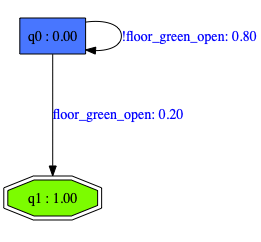

In [4]:
PDFA_MODEL_CONFIG_FILE_ORIGINAL = 'wombats/config/PDFA_merge_safety_into_prduct_original.yaml'
cosafe_specification_original = active_automata.get(automaton_type='PDFA',
                                         graph_data=PDFA_MODEL_CONFIG_FILE_ORIGINAL)

cosafe_specification_original.draw('_'.join([EXPERIMENT_NAME, ENV_ID, 'PDFA']))

### Now convert !floor_green_open for easiness
"not" (!) transition is not yet being supported in wombats library

Since we only have three symbols {empty_red_open, water_blue_open, floor_green_open}, !floor_green_open is converted to empty_red_open || water_blue_open

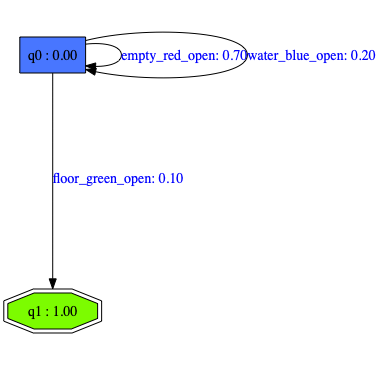

{'empty_red_open', 'floor_green_open', 'water_blue_open'}


In [5]:
cosafe_specification = active_automata.get(automaton_type='PDFA',
                                         graph_data=PDFA_MODEL_CONFIG_FILE)

cosafe_specification.draw('_'.join([EXPERIMENT_NAME, ENV_ID, 'PDFA']))
print(cosafe_specification.symbols)

### Specify a safety DFA
"If the robot goes in the water, it has to wait at least 2 time steps before going to the green area (charging station)". The original Formula: 

    G(water -> X (!green & X !green))

We can even add the drying condition (yellow region) to it. "If the robot goes in the water, it has to wait at least 2 time steps before going to the green area (charging station) unless it visits a drying region (yellow)":

    ϕ = G(water -> X (!green & (yellow | X !green) ) )
    
The sink states can be deleted but it is left as it is in this example.

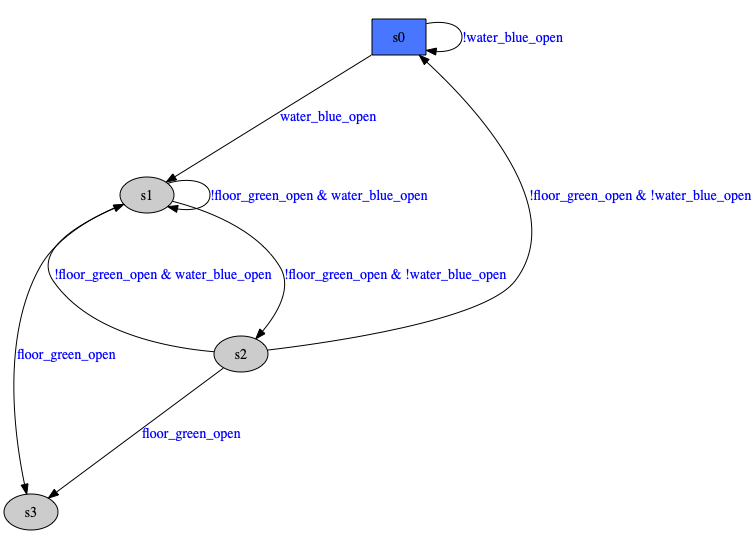

In [6]:
safe_specification = active_automata.get(automaton_type='DFA',
                                         graph_data=DFA_MODEL_CONFIG_FILE)
safe_specification.draw('_'.join([EXPERIMENT_NAME, ENV_ID, 'DFA']))

### Loading in the Simplified Transition System for Demonstration

We are going to demonstrate this specification using a simplified robot that can only go in each cardinal direction

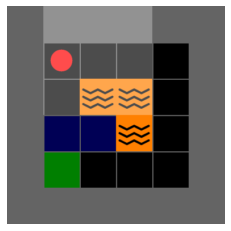

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/systems/minigrid.py:717: RuntimeWarning: could not find any goal objects.
  warnings.warn(msg, RuntimeWarning)


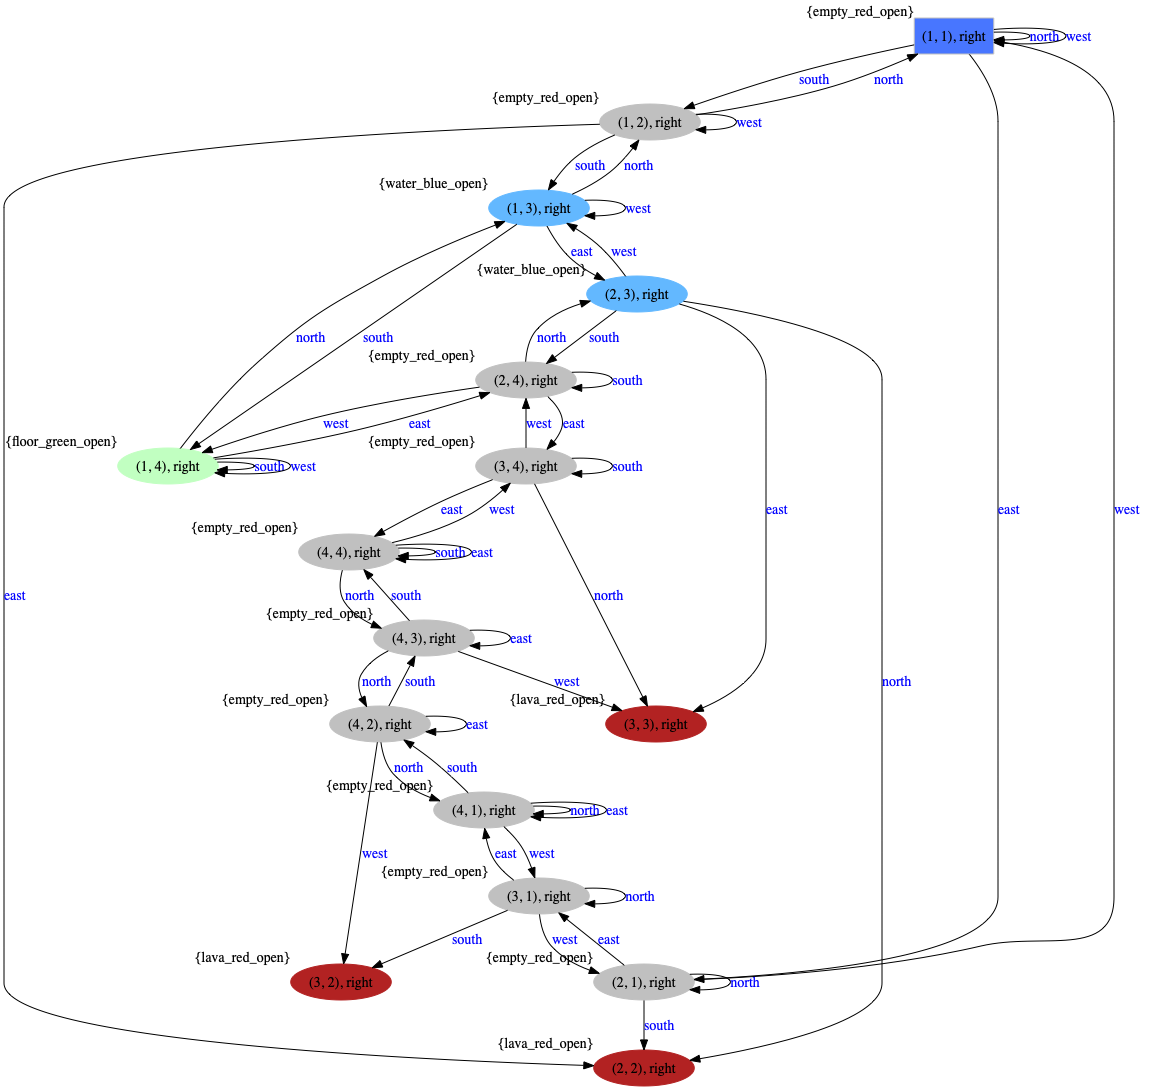

Observations:  {'lava_red_open', 'empty_red_open', 'floor_green_open', 'water_blue_open'}
Environment Actions:  [<SimpleStaticActions.north: 0>, <SimpleStaticActions.south: 1>, <SimpleStaticActions.east: 2>, <SimpleStaticActions.west: 3>]
Transition System's Symbols:  {'east', 'west', 'north', 'south'}


In [7]:
env = gym.make(ENV_ID)

env = StaticMinigridTSWrapper(env, actions_type='simple_static',
                              monitor_log_location=GYM_MONITOR_LOG_DIR)
env.reset()
env.render_notebook()

minigrid_TS = active_automata.get(automaton_type='TS', graph_data=env,
                                  graph_data_format='minigrid')
minigrid_TS.draw('_'.join([EXPERIMENT_NAME, ENV_ID, 'TS']))

print('Observations: ', minigrid_TS.observations)
print('Environment Actions: ', list(minigrid_TS.actions))
print("Transition System's Symbols: ", minigrid_TS.symbols)

## 1.2) Building the Product Automaton from just Cosafe & DTS
To create demonstrations of the specification as applied to the simple robot & env. from above, we are going to start by taking their product 

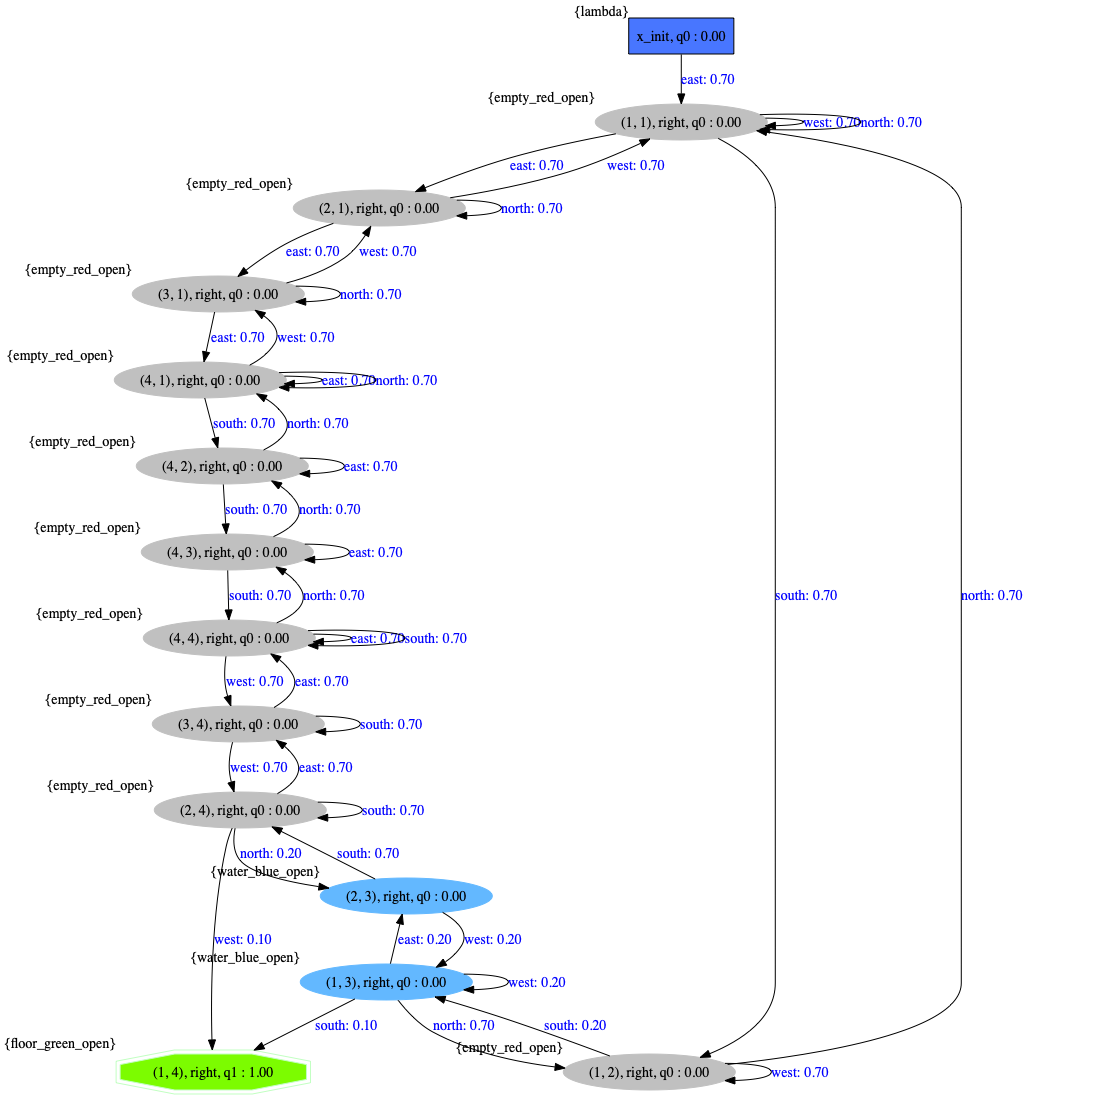

In [8]:
product = active_automata.get(automaton_type='Product',
                              graph_data=(minigrid_TS,
                                          cosafe_specification),
                             show_steps=False)
product.draw('_'.join([EXPERIMENT_NAME, ENV_ID, 'model','product']))

A normal product automaton CANNOT project the valid transition probability distributions from the specification onto itself, so ONLY for sampling traces from the product, we normalize the transition distribution in the product.

While this changes the probability value associated with output strings sampled from the product different than when producing a run in the specification under the output string, the *relative frequencies* of the output strings of the product and of the specification will be the same.

This means that sampling on the normalized product will produce corpuses of output strings consistent in relative frequency with the specification's language distribution when projected on the transition system dynamics of the system being specified.

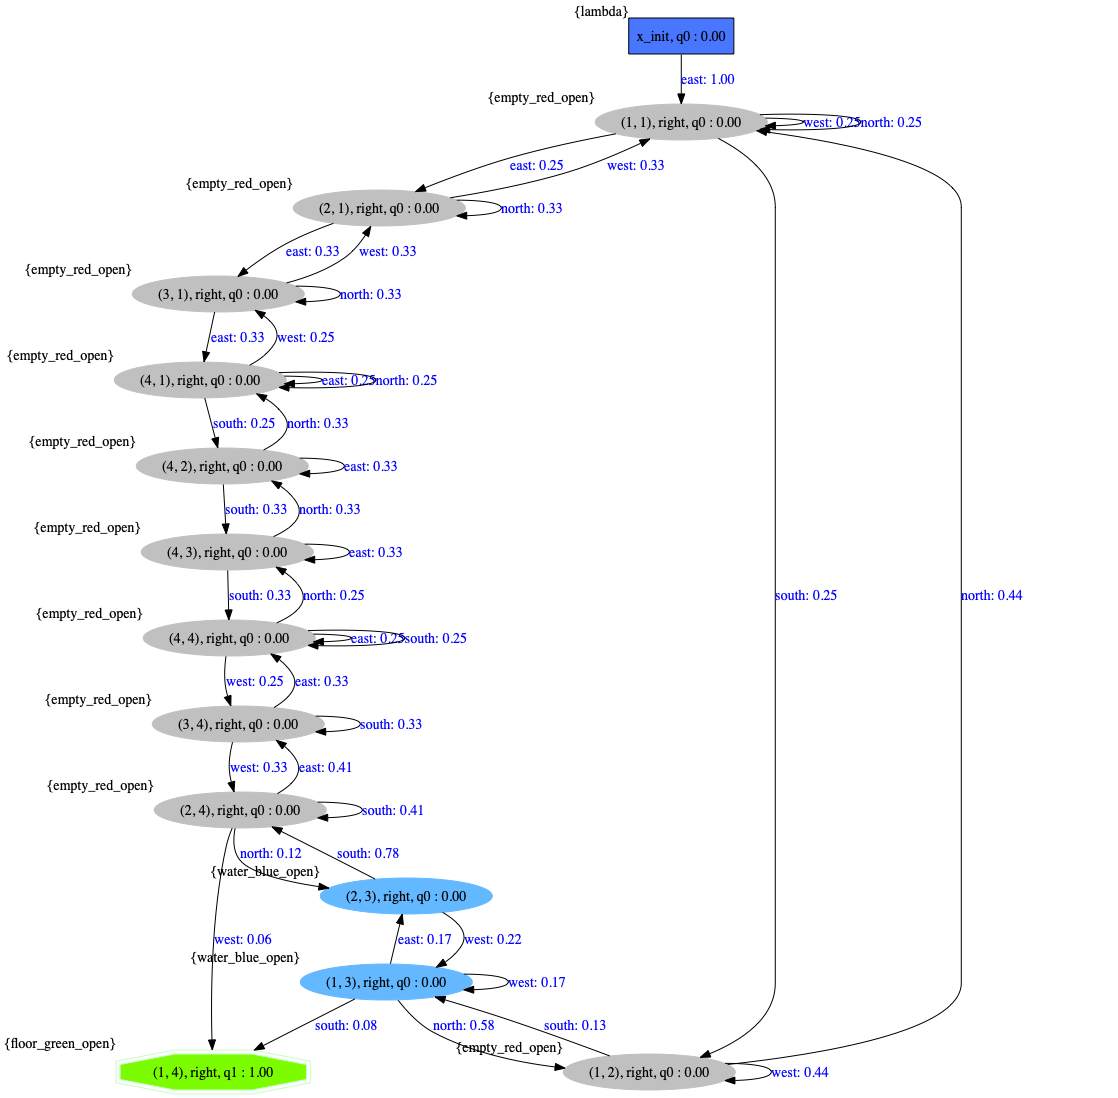

In [9]:
normalized_product = active_automata.get(automaton_type='Product',
                                         graph_data=(minigrid_TS,
                                                     cosafe_specification),
                                         normalize_trans_probabilities=True)
normalized_product.draw('_'.join([EXPERIMENT_NAME, ENV_ID, 'model', 'norm',
                                  'product']))

### Compute strategy based on the Product
Note that the agent is being able to reach the green floor but also stepping on the water. 
This is the cause of just using "Cosafety" property to compute a strategy.
We have to take into account of the "safety" property.  

In [10]:
(MPS_controller,
 prob_of_controls_under_spec) = product.compute_strategy()

print('Minimum sampled string length:', len(MPS_controller))
print('Maximum trace probability:', prob_of_controls_under_spec)

output_string, visited_states, video_path = minigrid_TS.run(MPS_controller,
                                                            record_video=True)
print(output_string)
print(visited_states)
print('saving ... ', video_path)
Video(video_path, embed=True, html_attributes="controls muted autoplay loop")


Minimum sampled string length: 3
Maximum trace probability: 0.0098
['empty_red_open', 'empty_red_open', 'water_blue_open', 'floor_green_open']
['(1, 1), right', '(1, 2), right', '(1, 3), right', '(1, 4), right']
saving ...  /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/minigrid_env_logs/openaigym.video.16.20237.video000016.mp4


## 1.3) Compose a Product with Cosafety, Safety and DTS


### First, compose a specificatoin with "Safety" property with a "Cosafety" PDFA

Safe LTL, Safety Formula, Safety Property

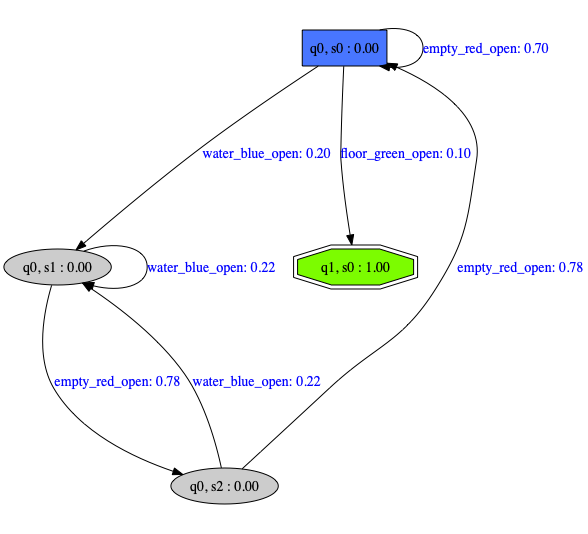

In [11]:
pdfa_specification = active_automata.get(automaton_type='PDFA',
                                         graph_data=(cosafe_specification,
                                                     safe_specification),
                                         graph_data_format='existing_objects',
                                         normalize_trans_probabilities=True)
pdfa_specification.draw('_'.join([EXPERIMENT_NAME, ENV_ID, 'PDFA', 'DFA']))

### Compose a Product with a composed specification and DTS

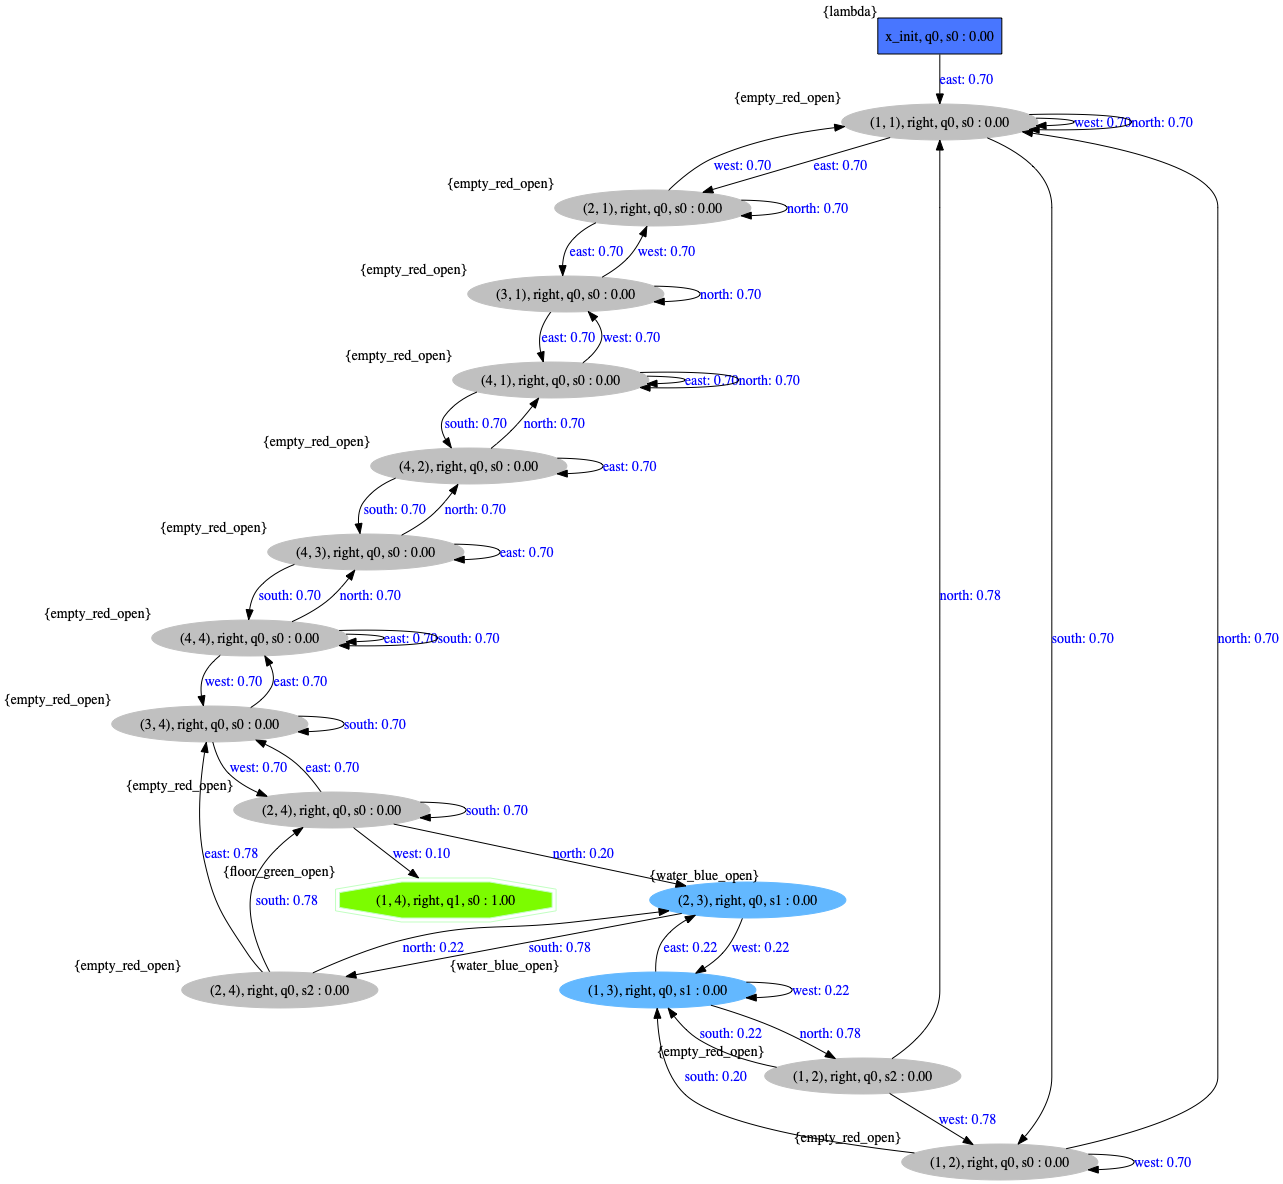

In [12]:
merged_product = active_automata.get(automaton_type='Product',
                                     graph_data=(minigrid_TS, 
                                                 pdfa_specification),
                                     show_steps=False)
merged_product.draw('_'.join([EXPERIMENT_NAME, ENV_ID, 'model','merged_product']))

In [13]:
(MPS_controller,
 prob_of_controls_under_spec) = merged_product.compute_strategy()

print('Strategy', MPS_controller)
print('Minimum sampled string length:', len(MPS_controller))
print('Maximum trace probability:', prob_of_controls_under_spec)

output_string, visited_states, video_path = minigrid_TS.run(MPS_controller,
                                                            record_video=True)
print('saving ... ', video_path)
Video(video_path, embed=True, html_attributes="controls muted autoplay loop")


Strategy ['east', 'east', 'east', 'south', 'south', 'south', 'west', 'west', 'west']
Minimum sampled string length: 9
Maximum trace probability: 0.004035360700000004
saving ...  /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/minigrid_env_logs/openaigym.video.17.20237.video000017.mp4


In [14]:
control_inputs = ['south', 'south', 'east', 'south', 'south', 'west']
output_string, visited_states, video_path = minigrid_TS.run(control_inputs,
                                                            record_video=True)
print('saving ... ', video_path)
print(output_string)
print(visited_states)
print('score', pdfa_specification.score(output_string))
Video(video_path, embed=True, html_attributes="controls muted autoplay loop")

saving ...  /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/minigrid_env_logs/openaigym.video.18.20237.video000018.mp4
['empty_red_open', 'empty_red_open', 'water_blue_open', 'water_blue_open', 'empty_red_open', 'empty_red_open', 'floor_green_open']
['(1, 1), right', '(1, 2), right', '(1, 3), right', '(2, 3), right', '(2, 4), right', '(2, 4), right', '(1, 4), right']
score 0.0013174211248285332


## 1.4) Change Cosafe's Transition Probabilities to observe a change in the path


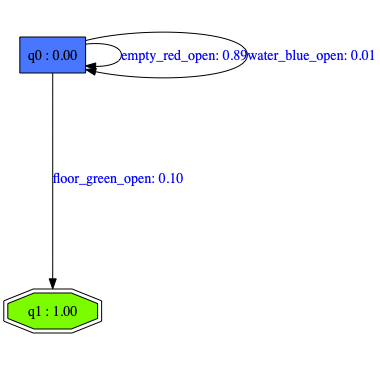

In [15]:
# Load original cosafe specificatoin
config_data = PDFABuilder.load_YAML_config_data(PDFA_MODEL_CONFIG_FILE)
# Change probabilities
config_data['edges']['q0']['q0']['probabilities'] = [0.89, 0.01]

# Save the dictt as a temp file
TEMP_PDFA_MODEL_CONFIG_FILE = os.path.join('/tmp', PDFA_MODEL_CONFIG_FILE)
Path(TEMP_PDFA_MODEL_CONFIG_FILE).parent.mkdir(parents=True, exist_ok=True)
    
with open(TEMP_PDFA_MODEL_CONFIG_FILE, 'w') as f:
    documents = yaml.dump(config_data, f)
    
cosafe_specification2 = active_automata.get(automaton_type='PDFA',
                                         graph_data=TEMP_PDFA_MODEL_CONFIG_FILE)

cosafe_specification2.draw('_'.join([EXPERIMENT_NAME, ENV_ID, 'PDFA']))

In [16]:
# Compose a new PDFA with Safe DFA
pdfa_specification2 = active_automata.get(automaton_type='PDFA',
                                         graph_data=(cosafe_specification2,
                                                     safe_specification),
                                         graph_data_format='existing_objects',
                                         normalize_trans_probabilities=True)
# Compose a Product  with DTS
merged_product2 = active_automata.get(automaton_type='Product',
                                     graph_data=(minigrid_TS, 
                                                 pdfa_specification2),
                                     show_steps=False)
# Compute a strategy
(MPS_controller2,
 prob_of_controls_under_spec2) = merged_product2.compute_strategy()

print('Strategy', MPS_controller2)
print('Minimum sampled string length:', len(MPS_controller2))
print('Maximum trace probability:', prob_of_controls_under_spec2)

# Run the controller on the original DTS
output_string, visited_states, video_path = minigrid_TS.run(MPS_controller2,
                                                            record_video=True)
print('saving ... ', video_path)
Video(video_path, embed=True, html_attributes="controls muted autoplay loop")


Strategy ['east', 'east', 'east', 'south', 'south', 'south', 'west', 'west', 'west']
Minimum sampled string length: 9
Maximum trace probability: 0.03503564037074853
saving ...  /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/minigrid_env_logs/openaigym.video.19.20237.video000019.mp4


# Experiment 2: Learn the Cosafe PDFA from samples and find the optimal strategy like above


### first sample traces from the composed product

In [17]:
num_samples = 100
max_trace_length = 20
(traces,
 trace_lengths,
 trace_probs) = pdfa_specification.generate_traces(num_samples, N=max_trace_length)

# create a training-test split for model validation after training 
test_size = 0.2
(traces_train, traces_test,
 traceLengths_train, traceLengths_test,
 trace_probs_train, trace_probs_test) = train_test_split(traces,
                                                         trace_lengths,
                                                         trace_probs,
                                                         test_size=test_size)

# Write learning data to files for inference
train_data_file = pdfa_specification.write_traces_to_file(
    traces_train,
    alphabet_size=pdfa_specification.alphabet_size,
    file=LEARNING_TRAIN_DATA_REL_FILEPATH)
test_data_file = pdfa_specification.write_traces_to_file(
    traces_test,
    alphabet_size=pdfa_specification.alphabet_size,
    file=LEARNING_TEST_DATA_REL_FILEPATH)

In [18]:
flexfringe = FlexfringeInterface(output_directory=LEARNER_DATA_DIR)

welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
The tree is not yet constructed
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat runningm99956 m99938 x80 

found intermediate solution with 2 and 2 red states
No valid solver specified, skipping...
dfasat runn

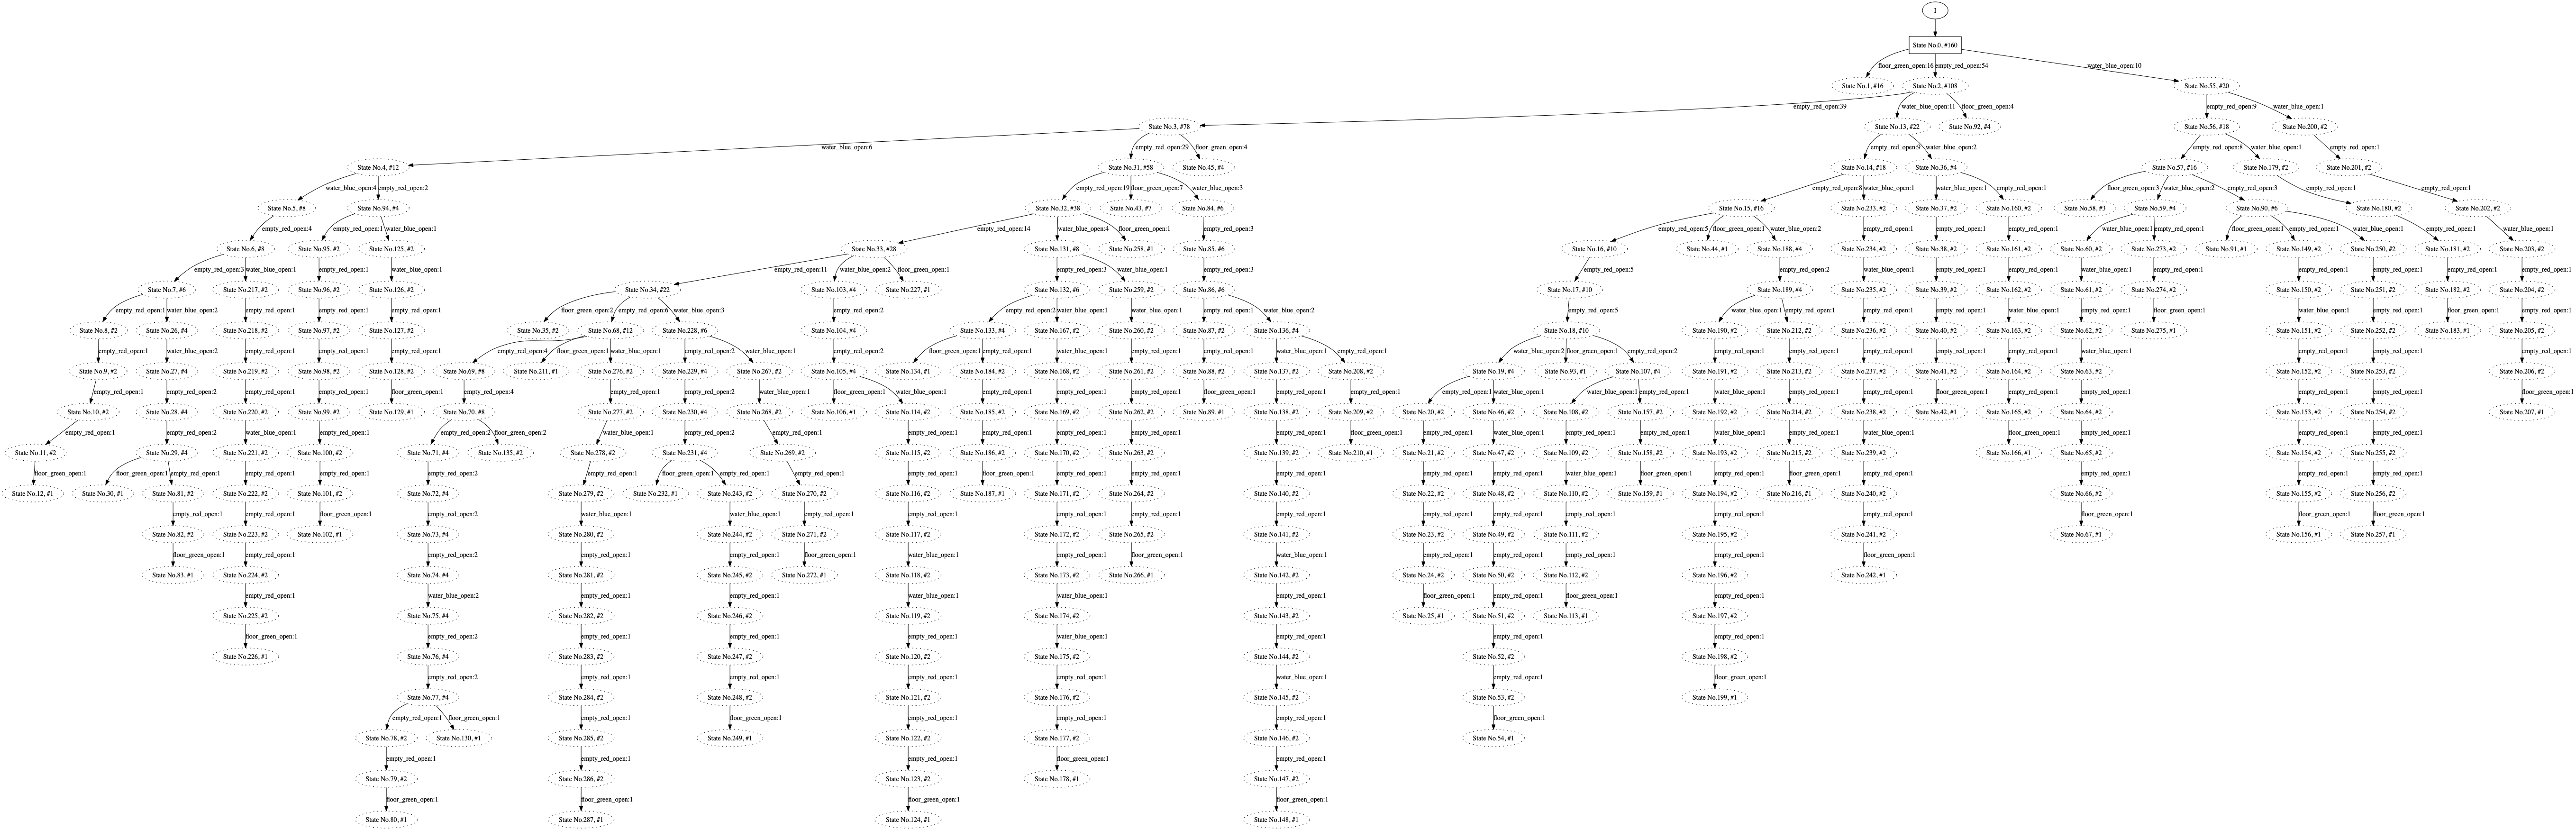

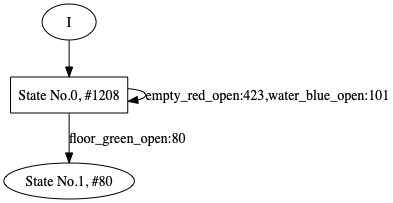

In [19]:
data = flexfringe.infer_model(training_file=train_data_file,
                              h='kldistance', #  --heuristic-name
                              d='kl_data',  # --data-name
#                               h='alergia', #  --heuristic-name
#                               d='alergia_data',  # --data-name
                              m='2',  # --method
                              n='2',  # --runs
                              x='0',  # --extend
                              w='0',  # --shallowfirst
                              a='0',  # --largestblue
                              b='0',  # --blueblue
                              f='0',  # --finalred
                              I='1',  # --sinkson
                              t='1',  # --testmerge
                              q='0',  # --state_count
                              y='0',  # --symbol_count
                              p='0.95')  # --extrapar
flexfringe.draw_initial_model()
flexfringe.draw_learned_model()

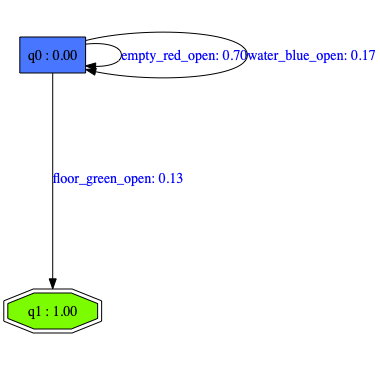

In [20]:
learned_fdfa = active_automata.get(automaton_type='FDFA',
                                   graph_data=flexfringe,
                                   graph_data_format='learning_interface')
learned_cosafe_specification = active_automata.get(automaton_type='PDFA',
                                   graph_data=learned_fdfa,
                                   graph_data_format='fdfa_object',
                                   merge_sinks=True)
learned_cosafe_specification.draw('_'.join([EXPERIMENT_NAME, ENV_ID, 'learned', 'PDFA']))

In [23]:
(specification_MPS,
 specification_MPS_prob, _) = pdfa_specification.most_probable_string()
print(f'Specification MPS: {specification_MPS}')
print(f'Probability of Spec. MPS in PDFA"s Language: {specification_MPS_prob}')

learned_model_MPS, learned_model_MPS_prob, _ = learned_cosafe_specification.most_probable_string()
print(f'Learned MPS: {learned_model_MPS}')
print(f'Probability of Learned MPS in PDFA"s Language: {learned_model_MPS_prob}')


Specification MPS: ['floor_green_open']
Probability of Spec. MPS in PDFA"s Language: 0.10000000000000002



Learned MPS: ['floor_green_open']
Probability of Learned MPS in PDFA"s Language: 0.14260249554367202


In [24]:
test_perplexity = learned_cosafe_specification.perplexity(traces_test, trace_probs_test)
train_perplexity = learned_cosafe_specification.perplexity(traces_train, trace_probs_train)
target_perplexity = pdfa_specification.perplexity(traces_test, trace_probs_test)

print(f"Test Perplexity of Learned Model: {test_perplexity}")
print(f"Training Perplexity of Learned Model: {train_perplexity}")
print(f"Perplexity of Target Model: {target_perplexity}")

Test Perplexity of Learned Model: 5.288581248478591
Training Perplexity of Learned Model: 410.514657162364
Perplexity of Target Model: 6.753402501756746


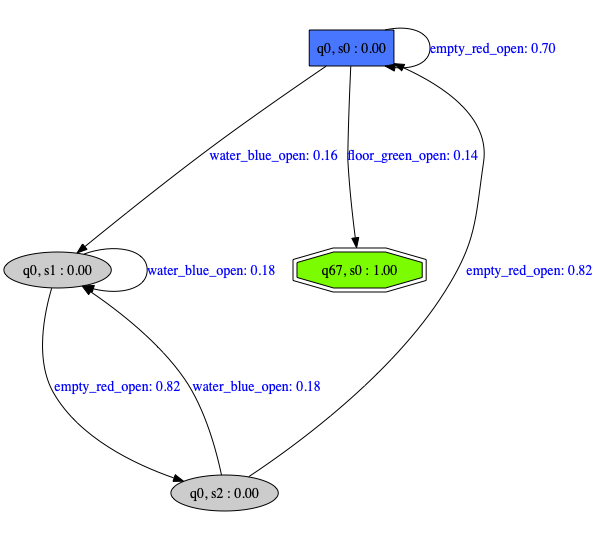

In [25]:
learned_pdfa_specification = active_automata.get(automaton_type='PDFA',
                                         graph_data=(learned_cosafe_specification,
                                                     safe_specification),
                                         graph_data_format='existing_objects',
                                         normalize_trans_probabilities=True,
                                         delete_sinks=True)
learned_pdfa_specification.draw('_'.join([EXPERIMENT_NAME, ENV_ID, 'Learned', 'PDFA', 'DFA']))

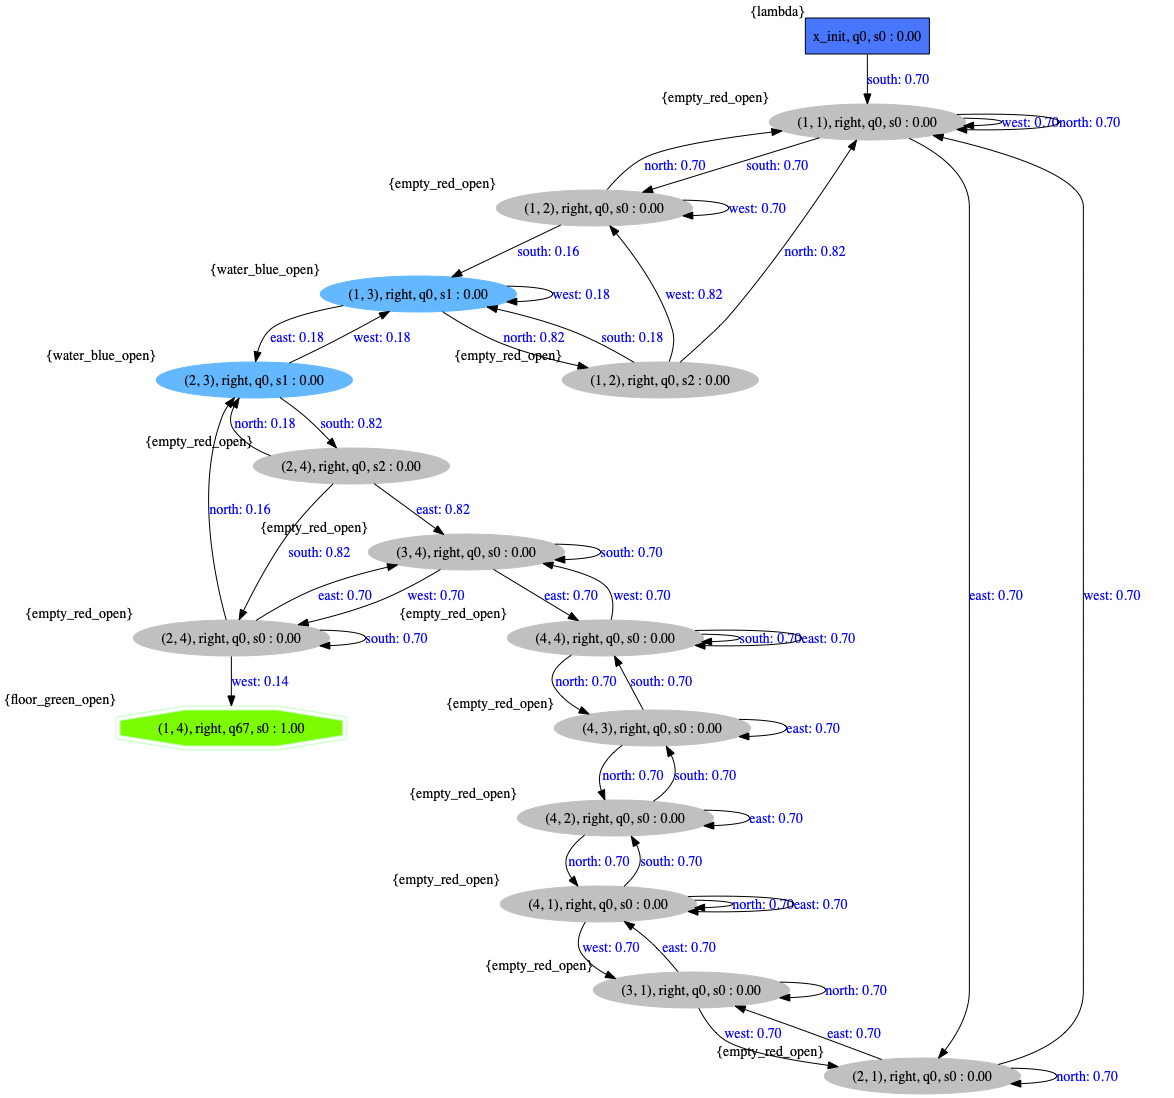

In [26]:
learned_product = active_automata.get(automaton_type='Product',
                                     graph_data=(minigrid_TS, 
                                                 learned_pdfa_specification),
                                     show_steps=False)
learned_product.draw('_'.join([EXPERIMENT_NAME, ENV_ID, 'model','learned_product']))

In [27]:
(MPS_controller,
 prob_of_controls_under_spec) = merged_product.compute_strategy()

print('Strategy', MPS_controller)
print('Minimum sampled string length:', len(MPS_controller))
print('Maximum trace probability:', prob_of_controls_under_spec)

output_string, visited_states, video_path = minigrid_TS.run(MPS_controller,
                                                            record_video=True)
print('saving ... ', video_path)
Video(video_path, embed=True, html_attributes="controls muted autoplay loop")


Strategy ['east', 'east', 'east', 'south', 'south', 'south', 'west', 'west', 'west']
Minimum sampled string length: 9
Maximum trace probability: 0.004035360700000004
saving ...  /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/minigrid_env_logs/openaigym.video.20.76122.video000020.mp4


# Experiment 3: Observe how No. of Samples affect the learning result


In [81]:
def learn_pdfa(pdfa_specification, num_samples=1000, max_trace_length=20, num_iter=1):
    """
    :param pdfa_specification: 
    :param num_samples: 
    :param max_trace_length: 
    :param num_iter: 
    :returns: dict
    """
    if num_iter < 1:
        raise ValueError('num_iter must be >= 1')
    
    train_results = []
    target_results = []
    
    while len(train_results) != num_iter:
        # Note: This is just for checking if there is any Error 
        (trained_pdfa_specification,
         train_result,
         target_result) = _learn_pdfa(pdfa_specification, num_samples, max_trace_length)
        try:
            print('-'*50, len(train_results)+1, 'th iteration ...', '-'*50)
            (trained_pdfa_specification, 
             train_result,
             target_result) = _learn_pdfa(pdfa_specification, num_samples, max_trace_length)
            train_results.append(train_result)
            target_results.append(target_result)
            print('-'*50, 'Iterations Done: ', len(train_results), )
        except:
            pass
        
    metrics = list(train_results[0].keys())
    train_mean_result = {metric: 0.0 for metric in metrics}
    target_mean_result = {metric: 0.0 for metric in metrics}
    
    for metric in metrics:
        metric_val = train_results[0][metric]
        if isinstance(metric_val, int) or isinstance(metric_val, float):
            train_mean_result[metric] = np.mean([result[metric] for result in train_results])
            target_mean_result[metric] = np.mean([result[metric] for result in target_results])
        else:
            train_mean_result[metric] = [result[metric] for result in train_results]
            target_mean_result[metric] = [result[metric] for result in target_results]
        
    return train_mean_result, target_mean_result


def _learn_pdfa(pdfa_specification, num_samples=1000, max_trace_length=20):
    (traces,
     trace_lengths,
     trace_probs) = pdfa_specification.generate_traces(num_samples, N=max_trace_length)

    # create a training-test split for model validation after training 
    test_size = 0.2
    (traces_train, traces_test,
     traceLengths_train, traceLengths_test,
     trace_probs_train, trace_probs_test) = train_test_split(traces,
                                                             trace_lengths,
                                                             trace_probs,
                                                             test_size=test_size)

    # Write learning data to files for inference
    train_data_file = pdfa_specification.write_traces_to_file(
        traces_train,
        alphabet_size=pdfa_specification.alphabet_size,
        file=LEARNING_TRAIN_DATA_REL_FILEPATH)
    test_data_file = pdfa_specification.write_traces_to_file(
        traces_test,
        alphabet_size=pdfa_specification.alphabet_size,
        file=LEARNING_TEST_DATA_REL_FILEPATH)
    
    flexfringe = FlexfringeInterface(output_directory=LEARNER_DATA_DIR)
    
    data = flexfringe.infer_model(training_file=train_data_file,
                              h='kldistance', #  --heuristic-name
                              d='kl_data',  # --data-name
                              m='2',  # --method
                              n='2',  # --runs
                              x='0',  # --extend
                              w='0',  # --shallowfirst
                              a='0',  # --largestblue
                              b='0',  # --blueblue
                              f='0',  # --finalred
                              I='1',  # --sinkson
                              t='1',  # --testmerge
                              q='0',  # --state_count
                              y='0',  # --symbol_count
                              p='0.95')  # --extrapar
    trained_fdfa = active_automata.get(automaton_type='FDFA',
                                   graph_data=flexfringe,
                                   graph_data_format='learning_interface')
    trained_cosafe_specification = active_automata.get(automaton_type='PDFA',
                                   graph_data=trained_fdfa,
                                   graph_data_format='fdfa_object',
                                   merge_sinks=True)
    trained_pdfa_specification = active_automata.get(automaton_type='PDFA',
                                         graph_data=(trained_cosafe_specification,
                                                     safe_specification),
                                         graph_data_format='existing_objects',
                                         normalize_trans_probabilities=True,
                                         delete_sinks=False)
    
    train_result = evaluate_pdfa_specification(trained_pdfa_specification, minigrid_TS, traces_test, trace_probs_test)
    target_result = evaluate_pdfa_specification(pdfa_specification, minigrid_TS, traces_test, trace_probs_test)
    
    return trained_pdfa_specification, train_result, target_result

def evaluate_pdfa_specification(pdfa_specification_, minigrid_TS_, traces_test_, trace_probs_test_):
    num_node = len(list(pdfa_specification_.nodes.keys()))
    num_edge = len(list(pdfa_specification_.edges.keys()))
    MPS, MPS_prob, _ = pdfa_specification_.most_probable_string()
    perplexity = pdfa_specification_.perplexity(traces_test, trace_probs_test, ignore_reject_trace=True)
    
    merged_product_ = active_automata.get(automaton_type='Product',
                                     graph_data=(minigrid_TS_, 
                                                 pdfa_specification_),
                                     show_steps=False)
    num_node_in_prod = len(list(merged_product_.nodes.keys()))
    num_edge_in_prod = len(list(merged_product_.edges.keys()))
    
    (MPS_controller_, 
     prob_of_controls_under_spec) = merged_product_.compute_strategy()
    output_string, visited_states, video_path = minigrid_TS_.run(MPS_controller_,
                                                                record_video=False)
    
    return {'No. of Nodes in the Specification PDFA': num_node, 
            'No. of Edges in the Specification PDFA': num_edge, 
            'No. of Nodes in the Product': num_node_in_prod,
            'No. of Edges in the Product': num_edge_in_prod,
            'Shortest Path Length': len(output_string),
            'Output String': output_string,
            'Perplexity': perplexity}

## Compare, No. of nodes, edges, true perplexity, and No. of steps in the shortest path, Probability of the path

In [84]:
num_samples = np.logspace(1, 2, num=10)
num_iter = 10

train_results = {}
target_results = {}

for i, num_sample in enumerate(num_samples):
    print('-'*50, 'No. of Samples: ', num_sample, '-'*50)
    train_result, target_result  = learn_pdfa(pdfa_specification,
                                              num_sample,
                                              num_iter=num_iter)
    
    metrics = list(train_result.keys())
    
    for metric in metrics:
        train_value = train_result[metric]
        target_value = target_result[metric]
        
        if metric not in train_results:
            train_results[metric] = [train_value]
            target_results[metric] = [target_value]
        else:
            train_results[metric].append(train_value)
            target_results[metric].append(target_value)

-------------------------------------------------- No. of Samples:  10.0 --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99920  m99922  x8  

found i


-------------------------------------------------- 1 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99975  m99925  x8  

found int


-------------------------------------------------- Iterations Done:  1
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99957  m99936  x8  

found intermediate solution with 2 and 2 red states
No vali


-------------------------------------------------- 2 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99951  x8  m99919  m99906  x4 


-------------------------------------------------- Iterations Done:  2
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99938  m99953  x8  

found intermediate solution with 2 and 2 red states
No vali


-------------------------------------------------- 3 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99962  m99969  x8  

found int


-------------------------------------------------- Iterations Done:  3
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99961  x6  m99920  m99923  x8  

found intermediate solution with 3 and 3 red st


-------------------------------------------------- 4 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99969  m99935  x8  

found int


-------------------------------------------------- Iterations Done:  4
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99979  m99956  x8  

found intermediate solution with 2 and 2 red states
No vali


-------------------------------------------------- 5 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99971  m99948  x8  

found int


-------------------------------------------------- Iterations Done:  5
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99982  m99932  x8  

found intermediate solution with 2 and 2 red states
No vali


-------------------------------------------------- 6 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99962  m99953  x8  

found int


-------------------------------------------------- Iterations Done:  6
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99956  m99944  x8  

found intermediate solution with 2 and 2 red states
No vali


-------------------------------------------------- 7 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99987  m99958  x8  

found int


-------------------------------------------------- Iterations Done:  7
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99974  m99917  x8  

found intermediate solution with 2 and 2 red states
No vali


-------------------------------------------------- 8 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99979  m99954  x8  

found int


-------------------------------------------------- Iterations Done:  8
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99978  m99951  x8  

found intermediate solution with 2 and 2 red states
No vali


-------------------------------------------------- 9 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99955  m99918  x8  

found int


-------------------------------------------------- Iterations Done:  9
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99953  m99940  x8  

found intermediate solution with 2 and 2 red states
No vali


-------------------------------------------------- 10 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99927  m99930  x8  

found in


-------------------------------------------------- Iterations Done:  10
-------------------------------------------------- No. of Samples:  12.91549665014884 --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode se


-------------------------------------------------- 1 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99980  m99948  x9  

found int


-------------------------------------------------- Iterations Done:  1
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99945  m99958  x9  

found intermediate solution with 2 and 2 red states
No vali


-------------------------------------------------- 2 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99952  m99939  x9  

found int


-------------------------------------------------- Iterations Done:  2
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99945  m99926  x9  

found intermediate solution with 2 and 2 red states
No vali


-------------------------------------------------- 3 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99965  m99945  x9  

found int


-------------------------------------------------- Iterations Done:  3
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99969  m99953  x9  

found intermediate solution with 2 and 2 red states
No vali


-------------------------------------------------- 4 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99963  m99930  x9  

found int


-------------------------------------------------- Iterations Done:  4
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99962  m99951  x9  

found intermediate solution with 2 and 2 red states
No vali


-------------------------------------------------- 5 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99954  m99923  x9  

found int


-------------------------------------------------- Iterations Done:  5
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99954  m99934  x9  

found intermediate solution with 2 and 2 red states
No vali


-------------------------------------------------- 6 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99964  m99954  x9  

found int


-------------------------------------------------- Iterations Done:  6
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99937  m99934  x9  

found intermediate solution with 2 and 2 red states
No vali


-------------------------------------------------- 7 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running x10  m99939  x10  m99969  m9994


-------------------------------------------------- Iterations Done:  7
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99938  m99935  x9  

found intermediate solution with 2 and 2 red states
No vali


-------------------------------------------------- 8 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99955  m99940  x9  

found int


-------------------------------------------------- Iterations Done:  8
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99971  m99936  x9  

found intermediate solution with 2 and 2 red states
No vali


-------------------------------------------------- 9 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99975  m99907  x9  

found int


-------------------------------------------------- Iterations Done:  9
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99972  m99948  x9  

found intermediate solution with 2 and 2 red states
No vali


-------------------------------------------------- 10 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99935  x10  m99960  m99955  x


-------------------------------------------------- Iterations Done:  10
-------------------------------------------------- No. of Samples:  16.68100537200059 --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode se


-------------------------------------------------- 1 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99976  m99950  x12  

found in


-------------------------------------------------- Iterations Done:  1
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99966  m99960  x12  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 2 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99964  m99914  x12  

found in


-------------------------------------------------- Iterations Done:  2
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99959  m99929  x12  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 3 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99943  m99946  x12  

found in


-------------------------------------------------- Iterations Done:  3
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99978  m99955  x12  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 4 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99967  m99952  x12  

found in


-------------------------------------------------- Iterations Done:  4
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99968  m99930  x12  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 5 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99982  m99939  x12  

found in


-------------------------------------------------- Iterations Done:  5
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99974  m99927  x12  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 6 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99966  m99946  x12  

found in


-------------------------------------------------- Iterations Done:  6
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99949  m99942  x12  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 7 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99949  m99955  x12  

found in


-------------------------------------------------- Iterations Done:  7
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99981  m99954  x12  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 8 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99965  m99937  x12  

found in


-------------------------------------------------- Iterations Done:  8
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99976  m99957  x12  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 9 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running x12  m99924  m99930  m99924  x7


-------------------------------------------------- Iterations Done:  9
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99973  m99953  x12  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 10 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99966  m99933  x12  

found i


-------------------------------------------------- Iterations Done:  10
-------------------------------------------------- No. of Samples:  21.544346900318832 --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode s


-------------------------------------------------- 1 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99954  m99944  x16  

found in


-------------------------------------------------- Iterations Done:  1
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99967  m99945  x16  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 2 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99962  m99951  x16  

found in


-------------------------------------------------- Iterations Done:  2
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99972  m99956  x16  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 3 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99959  m99954  x16  

found in


-------------------------------------------------- Iterations Done:  3
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99977  m99932  x16  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 4 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99967  m99918  x16  

found in


-------------------------------------------------- Iterations Done:  4
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99957  m99932  x16  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 5 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99960  m99936  x16  

found in


-------------------------------------------------- Iterations Done:  5
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99972  m99951  x16  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 6 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99962  m99942  x16  

found in


-------------------------------------------------- Iterations Done:  6
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99979  m99965  x16  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 7 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99947  m99935  x16  

found in


-------------------------------------------------- Iterations Done:  7
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99974  m99951  x16  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 8 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99975  m99939  x16  

found in


-------------------------------------------------- Iterations Done:  8
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99953  m99941  x16  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 9 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99971  m99965  x16  

found in


-------------------------------------------------- Iterations Done:  9
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99975  m99959  x16  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 10 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99970  m99941  x16  

found i


-------------------------------------------------- Iterations Done:  10
-------------------------------------------------- No. of Samples:  27.825594022071243 --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode s


-------------------------------------------------- 1 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99964  m99939  x21  

found in


-------------------------------------------------- Iterations Done:  1
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99960  m99943  x21  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 2 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99919  m99944  x21  

found in


-------------------------------------------------- Iterations Done:  2
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99966  m99952  x21  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 3 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99964  m99943  x21  

found in


-------------------------------------------------- Iterations Done:  3
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99967  m99947  x21  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 4 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99982  m99927  x21  

found in


-------------------------------------------------- Iterations Done:  4
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99972  m99955  x21  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 5 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99957  m99951  x21  

found in


-------------------------------------------------- Iterations Done:  5
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99961  m99951  x21  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 6 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99964  m99929  x21  

found in


-------------------------------------------------- Iterations Done:  6
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99965  m99942  x21  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 7 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99976  m99942  x21  

found in


-------------------------------------------------- Iterations Done:  7
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99962  m99957  x21  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 8 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99975  m99939  x21  

found in


-------------------------------------------------- Iterations Done:  8
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99972  m99948  x21  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 9 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99978  m99944  x21  

found in


-------------------------------------------------- Iterations Done:  9
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99949  m99960  x21  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 10 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99953  m99948  x21  

found i


-------------------------------------------------- Iterations Done:  10
-------------------------------------------------- No. of Samples:  35.938136638046274 --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode s


-------------------------------------------------- 1 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99951  m99960  x28  

found in


-------------------------------------------------- Iterations Done:  1
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99973  m99938  x28  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 2 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99968  m99959  x28  

found in


-------------------------------------------------- Iterations Done:  2
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99962  m99953  x28  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 3 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99957  m99949  x28  

found in


-------------------------------------------------- Iterations Done:  3
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99952  m99946  x28  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 4 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99969  m99946  x28  

found in


-------------------------------------------------- Iterations Done:  4
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99972  m99960  x28  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 5 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99955  m99951  x28  

found in


-------------------------------------------------- Iterations Done:  5
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99957  m99937  x28  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 6 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99973  m99949  x28  

found in


-------------------------------------------------- Iterations Done:  6
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99966  m99944  x28  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 7 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99958  m99947  x28  

found in


-------------------------------------------------- Iterations Done:  7
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99928  m99934  x28  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 8 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99968  m99950  x28  

found in


-------------------------------------------------- Iterations Done:  8
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99969  m99935  x28  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 9 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99979  m99957  x28  

found in


-------------------------------------------------- Iterations Done:  9
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99973  m99924  x28  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 10 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99962  m99942  x28  

found i


-------------------------------------------------- Iterations Done:  10
-------------------------------------------------- No. of Samples:  46.41588833612777 --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode se


-------------------------------------------------- 1 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99964  m99953  x36  

found in


-------------------------------------------------- Iterations Done:  1
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99962  m99930  x36  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 2 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99964  m99934  x36  

found in


-------------------------------------------------- Iterations Done:  2
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99963  m99957  x36  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 3 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99959  m99948  x36  

found in


-------------------------------------------------- Iterations Done:  3
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99956  m99938  x36  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 4 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99955  m99950  x36  

found in


-------------------------------------------------- Iterations Done:  4
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99966  m99948  x36  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 5 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99969  m99945  x36  

found in


-------------------------------------------------- Iterations Done:  5
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99966  m99949  x36  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 6 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99963  m99933  x36  

found in


-------------------------------------------------- Iterations Done:  6
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99962  m99944  x36  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 7 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99970  m99957  x36  

found in


-------------------------------------------------- Iterations Done:  7
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99946  m99942  x36  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 8 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99959  m99944  x36  

found in


-------------------------------------------------- Iterations Done:  8
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99955  m99954  x36  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 9 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99971  m99942  x36  

found in


-------------------------------------------------- Iterations Done:  9
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99975  m99945  x36  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 10 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99972  m99946  x36  

found i


-------------------------------------------------- Iterations Done:  10
-------------------------------------------------- No. of Samples:  59.94842503189409 --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode se


-------------------------------------------------- 1 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99976  m99952  x47  

found in


-------------------------------------------------- Iterations Done:  1
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99965  m99945  x47  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 2 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99971  m99953  x47  

found in


-------------------------------------------------- Iterations Done:  2
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99971  m99950  x47  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 3 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99949  m99944  x47  

found in


-------------------------------------------------- Iterations Done:  3
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99975  m99946  x47  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 4 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99975  m99944  x47  

found in


-------------------------------------------------- Iterations Done:  4
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99964  m99945  x47  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 5 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99965  m99933  x47  

found in


-------------------------------------------------- Iterations Done:  5
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99972  m99948  x47  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 6 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99972  m99951  x47  

found in


-------------------------------------------------- Iterations Done:  6
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99962  m99935  x47  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 7 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99976  m99947  x47  

found in


-------------------------------------------------- Iterations Done:  7
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99969  m99952  x47  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 8 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99966  m99952  x47  

found in


-------------------------------------------------- Iterations Done:  8
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99970  m99939  x47  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 9 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99969  m99951  x47  

found in


-------------------------------------------------- Iterations Done:  9
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99973  m99953  x47  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 10 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99974  m99955  x47  

found i


-------------------------------------------------- Iterations Done:  10
-------------------------------------------------- No. of Samples:  77.4263682681127 --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode sel


-------------------------------------------------- 1 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99969  m99938  x61  

found in


-------------------------------------------------- Iterations Done:  1
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99972  m99943  x61  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 2 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99966  m99952  x61  

found in


-------------------------------------------------- Iterations Done:  2
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99962  m99955  x61  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 3 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99958  m99957  x61  

found in


-------------------------------------------------- Iterations Done:  3
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99970  m99936  x61  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 4 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99965  m99959  x61  

found in


-------------------------------------------------- Iterations Done:  4
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99967  m99955  x61  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 5 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99961  m99960  x61  

found in


-------------------------------------------------- Iterations Done:  5
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99972  m99939  x61  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 6 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99964  m99940  x61  

found in


-------------------------------------------------- Iterations Done:  6
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99955  m99946  x61  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 7 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99975  m99949  x61  

found in


-------------------------------------------------- Iterations Done:  7
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99953  m99950  x61  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 8 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99973  m99939  x61  

found in


-------------------------------------------------- Iterations Done:  8
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99974  m99940  x61  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 9 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99968  m99948  x61  

found in


-------------------------------------------------- Iterations Done:  9
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99974  m99952  x61  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 10 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99968  m99945  x61  

found i


-------------------------------------------------- Iterations Done:  10
-------------------------------------------------- No. of Samples:  100.0 --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
readi


-------------------------------------------------- 1 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99963  m99958  x80  

found in


-------------------------------------------------- Iterations Done:  1
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99968  m99955  x80  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 2 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99964  m99944  x80  

found in


-------------------------------------------------- Iterations Done:  2
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99969  m99937  x80  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 3 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99963  m99952  x80  

found in


-------------------------------------------------- Iterations Done:  3
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99964  m99939  x80  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 4 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99963  m99945  x80  

found in


-------------------------------------------------- Iterations Done:  4
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99963  m99948  x80  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 5 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99967  m99948  x80  

found in


-------------------------------------------------- Iterations Done:  5
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99970  m99949  x80  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 6 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99963  m99954  x80  

found in


-------------------------------------------------- Iterations Done:  6
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99973  m99951  x80  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 7 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99967  m99957  x80  

found in


-------------------------------------------------- Iterations Done:  7
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99963  m99938  x80  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 8 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99966  m99941  x80  

found in


-------------------------------------------------- Iterations Done:  8
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99968  m99956  x80  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 9 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99958  m99928  x80  

found in


-------------------------------------------------- Iterations Done:  9
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99958  m99953  x80  

found intermediate solution with 2 and 2 red states
No val


-------------------------------------------------- 10 th iteration ... --------------------------------------------------
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe -h=kldistance -d=kl_data -m=2 -n=2 -x=0 -w=0 -a=0 -b=0 -f=0 -I=1 -t=1 -q=0 -y=0 -p=0.95 --output-dir=experiments/merge_safety_into_prduct/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/merge_safety_into_prduct/flexfringe_data/merge_safety_into_prduct_train 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99956  m99954  x80  

found i


-------------------------------------------------- Iterations Done:  10


No. of Nodes in the Specification PDFA
[4.1, 4.5, 4.1, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
----------------------------------------------------------------------------------------------------
No. of Edges in the Specification PDFA
[7.3, 8.3, 7.3, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0]
[7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0]
----------------------------------------------------------------------------------------------------
No. of Nodes in the Product
[16.0, 19.4, 17.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0]
[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0]
----------------------------------------------------------------------------------------------------
No. of Edges in the Product
[46.0, 57.3, 49.4, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0]
[46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0]
----------------------------------------------------------------------------------------------------
Shortest Path 

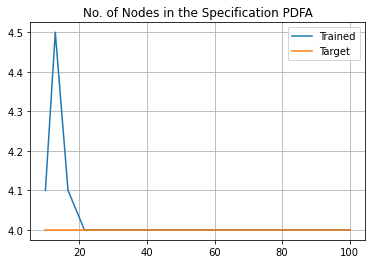

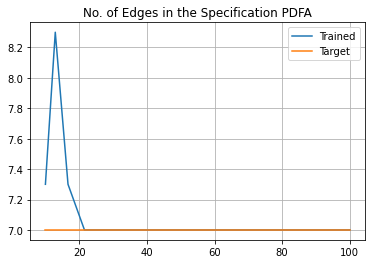

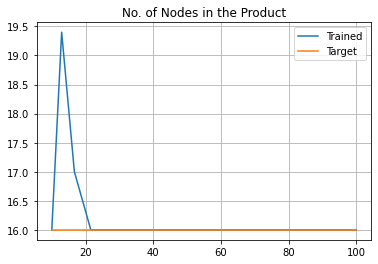

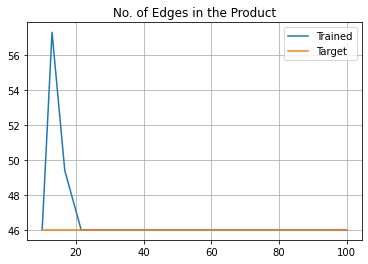

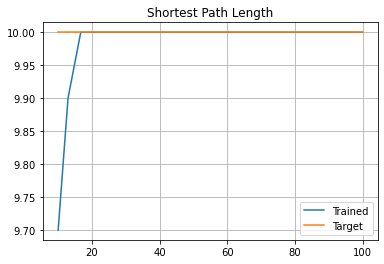

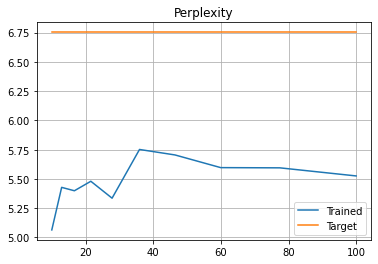

In [85]:
metrics = list(train_result.keys())

for i, metric in enumerate(metrics):
    print(metric)
    print(train_results[metric])
    print(target_results[metric])
    print('-'*100)
    
    # Do not visualize non-value results
    metric_val = train_results[metric][0]
    if isinstance(metric_val, list):
        continue

    plt.figure()
    plt.plot(num_samples, train_results[metric], label='Trained')
    plt.plot(num_samples, target_results[metric], label='Target')
    plt.grid()
    plt.legend()
    plt.title(metric)
    

In [86]:
for i, num_sample in enumerate(num_samples):
    print('No. of Samples: ', num_sample)
    print(train_results['Output String'][i])
    print(target_results['Output String'][i])
    print()

No. of Samples:  10.0
[['empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'floor_green_open'], ['empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'floor_green_open'], ['empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'floor_green_open'], ['empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'floor_green_open'], ['empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'floor_green_open'], ['empty_red_open', 'empty_red_open', 'empty_red_open', 'e